In [7]:
import instaloader
import pandas as pd
from collections import Counter
import re
import os
import time
from tqdm import tqdm
import matplotlib.pyplot as plt

# Collect Pages Info

In [ ]:
il = instaloader.Instaloader()
username = 'hide'
password = 'hide'
il.login(username, password)

In [ ]:
tech_pages = [
'techcrunch',
'wired',
'mashable',
'thenextweb',
'gizmodo',
'engadget',
'digitaltrends',
'cnet',
'theapplehub',
'androidauthority',
'gadgetflow',
'unboxtherapy',
'linustech',
'androidcentral',
'appleinsider',
'thegadgetshow',
'techradar',
'mkbhd',
'alcontech',
'verge',
'csharp_dotnet',
'madewithcode',
'gitHub',
'insidertech',
'microsoft',
'openai',
'python.hub',
'linux.teach',
'javascript.js',
'mobiscrub',
]

In [ ]:
columns = ["username", "full_name", "follower_count", "following_count", "num_posts",
           "avg_likes", "avg_comments", "avg_slides", "avg_caption_length", "top_10_tags"]
df = pd.DataFrame(columns=columns)

save_path = "instagram_data.csv"
if os.path.exists(save_path):
    df = pd.read_csv(save_path)

In [ ]:
def extract_hashtags(caption):
    return re.findall(r'#\w+', caption)

In [ ]:
for i, username in enumerate(tech_pages):
    if username in df['username'].values:
        print(f'Skipping {username}, already processed.')
        continue

    try:
        profile = instaloader.Profile.from_username(il.context, username)
        posts = profile.get_posts()

        total_likes = 0
        total_comments = 0
        total_slides = 0
        total_caption_length = 0
        hashtag_counter = Counter()
        num_analyzed_posts = 0

        for post in posts:
            total_likes += post.likes
            total_comments += post.comments
            total_slides += post.mediacount
            caption_length = len(post.caption) if post.caption else 0
            total_caption_length += caption_length
            hashtags = extract_hashtags(post.caption) if post.caption else []
            hashtag_counter.update(hashtags)
            num_analyzed_posts += 1
            time.sleep(0.5)
            if num_analyzed_posts >= 20:
                break

        avg_likes = total_likes / num_analyzed_posts if num_analyzed_posts else 0
        avg_comments = total_comments / num_analyzed_posts if num_analyzed_posts else 0
        avg_slides = total_slides / num_analyzed_posts if num_analyzed_posts else 0
        avg_caption_length = total_caption_length / num_analyzed_posts if num_analyzed_posts else 0
        top_10_tags = [tag for tag, _ in hashtag_counter.most_common(10)]

        r = {
            "username": username,
            "full_name": profile.full_name,
            "follower_count": profile.followers,
            "following_count": profile.followees,
            "num_posts": profile.mediacount,
            "avg_likes": avg_likes,
            "avg_comments": avg_comments,
            "avg_slides": avg_slides,
            "avg_caption_length": avg_caption_length,
            "top_10_tags": top_10_tags
        }
        d = pd.DataFrame([r])
        df = pd.concat([df, d], ignore_index=True)

        df.to_csv(save_path, index=False)
        print(f'{i+1}. {username} -> Data saved.')

    except instaloader.exceptions.ProfileNotExistsException:
        print(f'{i+1}. {username} -> Profile does not exist')
    except instaloader.exceptions.ConnectionException:
        print(f'{i+1}. {username} -> Connection error')
    except Exception as e:
        print(f'{i+1}. {username} -> An error occurred: {e}')

# Collect User Interactions

In [ ]:
page_interactions = {page: {'followers': set(), 'likers': set(), 'commenters': set()} for page in tech_pages}

In [ ]:
def collect_interactions(page, num_posts=40, user_limit=40):
    profile = instaloader.Profile.from_username(il.context, page)

    for follower in profile.get_followers():
        if len(page_interactions[page]['followers']) >= user_limit:
            break
        page_interactions[page]['followers'].add(follower.username)

    post_count = 0
    for post in profile.get_posts():
        try:
          if post_count >= num_posts:
              break
          # liker_count = 0
          # for like in post.get_likes():
          #     print('processing likes')
          #     if liker_count >= user_limit:
          #         break
          #     page_interactions[page]['likers'].add(like.username)
          #     liker_count += 1
          #     time.sleep(1)

          commenter_count = 0
          for comment in post.get_comments():
              if commenter_count >= user_limit:
                  break
              page_interactions[page]['commenters'].add(comment.owner.username)
              commenter_count += 1
              time.sleep(1)

          post_count += 1
        except Exception as e:
          print(f"Error processing post: {e}")

In [ ]:
page_interactions

{'techcrunch': {'followers': {'__instajunior',
   '_franpoma_',
   '_wen.ferr7',
   'aggelos95leg',
   'ahmad.sourchi',
   'ai_courses.experts',
   'aleena.b1',
   'andrewjordaan3228',
   'aptitude.io',
   'be_joyfulofficial',
   'cerebolabs',
   'dtmed',
   'exploring.8',
   'floorbotics',
   'gracefullyblunt__',
   'holabjorn',
   'jdwtravel01',
   'jordan_andrew22',
   'just_another_account.social',
   'kindrvaico',
   'lesniyowilly',
   'masboohayoli',
   'mbilals',
   'mirhanealecian',
   'padmanaba',
   'pasqualefloccari',
   'pfajarhadi3',
   'pranavbeingpranav',
   'ramisliawa',
   'realtyjefe',
   'sajan.j.joseph',
   'satyajit30',
   'sussuaranaspeed',
   'taner_bugra_kaya',
   'the.financepage365',
   'theengineersfm',
   'tylerrsalvatore',
   'ukfoodtech',
   'weysis_',
   'zeeinstavibes'},
  'likers': set(),
  'commenters': {'0mcxkakjgp',
   '13mxck',
   '1akrebel',
   '1dauntlz',
   '22marcelomedina',
   '30may_ra_',
   '333bellaluna',
   '333lifestrategy_',
   '6dupfupdp

In [ ]:
for page in tech_pages:
    collect_interactions(page)

# Calculate User Scores Based On Interactions

In [ ]:
user_interactions = {}
for page, interactions in page_interactions.items():
    for category, users in interactions.items():
        for user in users:
            if user not in user_interactions:
                user_interactions[user] = set()
            user_interactions[user].add(page)

common_users = [user for user, pages in user_interactions.items() if len(pages) > 1]

In [ ]:
def calculate_user_rating(interactions):
    user_scores = {}

    for username, pages in interactions.items():
        if username not in common_users:
            continue

        user_scores[username] = {} 
        for page in pages:
            score = 0
            if username in page_interactions[page]['followers']:
                score += 0.3
            if username in page_interactions[page]['likers']:
                score += 0.1
            if username in page_interactions[page]['commenters']:
                score += 0.2
            user_scores[username][page] = score

    return user_scores

user_ratings = calculate_user_rating(user_interactions)
print(user_ratings)

{'theengineersfm': {'wired': 0.3, 'techcrunch': 0.3}, 'mirhanealecian': {'digitaltrends': 0.3, 'techcrunch': 0.3, 'openai': 0.3}, 'lesniyowilly': {'techcrunch': 0.3, 'insidertech': 0.3}, 'be_joyfulofficial': {'digitaltrends': 0.3, 'techradar': 0.3, 'techcrunch': 0.3, 'cnet': 0.3}, 'the.financepage365': {'techcrunch': 0.3, 'insidertech': 0.3}, 'mbilals': {'digitaltrends': 0.3, 'techcrunch': 0.3}, 'holabjorn': {'wired': 0.3, 'techcrunch': 0.3}, 'realtyjefe': {'wired': 0.3, 'techcrunch': 0.3, 'mashable': 0.3}, 'sussuaranaspeed': {'techcrunch': 0.3, 'openai': 0.3}, 'jordan_andrew22': {'wired': 0.3, 'digitaltrends': 0.3, 'techcrunch': 0.3}, 'pasqualefloccari': {'verge': 0.3, 'techcrunch': 0.3}, '_wen.ferr7': {'techcrunch': 0.3, 'insidertech': 0.3}, 'aptitude.io': {'wired': 0.3, 'techcrunch': 0.3}, 'taner_bugra_kaya': {'wired': 0.3, 'thenextweb': 0.3, 'techcrunch': 0.3, 'mashable': 0.3}, 'aitrainingdev': {'microsoft': 0.2, 'techcrunch': 0.2}, 'adamsarwar': {'wired': 0.2, 'techcrunch': 0.2}, 

In [ ]:
def create_user_score_df(user_scores):
    data = []
    for username, page_scores in user_scores.items():
        for page, score in page_scores.items():
            data.append({'username': username, 'page': page, 'score': score})

    return pd.DataFrame(data)

user_score_df = create_user_score_df(user_ratings)

In [ ]:
user_score_df

,username,page,score
0,theengineersfm,wired,0.3
1,theengineersfm,techcrunch,0.3
2,mirhanealecian,digitaltrends,0.3
3,mirhanealecian,techcrunch,0.3
4,mirhanealecian,openai,0.3
...,...,...,...
850,python.science,python.hub,0.2
851,abodk7aled,python.hub,0.2
852,abodk7aled,javascript.js,0.2
853,viktorhonchar,linux.teach,0.2


In [ ]:
user_score_df.to_csv('common_user_ratings.csv', index=False)
print(user_score_df.head())

         username           page  score
0  theengineersfm          wired    0.3
1  theengineersfm     techcrunch    0.3
2  mirhanealecian  digitaltrends    0.3
3  mirhanealecian     techcrunch    0.3
4  mirhanealecian         openai    0.3


In [ ]:
user_score_df = pd.read_csv('common_user_ratings.csv')
user_score_df

,username,page,score
0,theengineersfm,wired,0.3
1,theengineersfm,techcrunch,0.3
2,mirhanealecian,digitaltrends,0.3
3,mirhanealecian,techcrunch,0.3
4,mirhanealecian,openai,0.3
...,...,...,...
850,python.science,python.hub,0.2
851,abodk7aled,python.hub,0.2
852,abodk7aled,javascript.js,0.2
853,viktorhonchar,linux.teach,0.2


# Collect User Infos

In [ ]:
users = user_score_df['username'].unique()
users

array(['theengineersfm', 'mirhanealecian', 'lesniyowilly',
       'be_joyfulofficial', 'the.financepage365', 'mbilals', 'holabjorn',
       'realtyjefe', 'sussuaranaspeed', 'jordan_andrew22',
       'pasqualefloccari', '_wen.ferr7', 'aptitude.io',
       'taner_bugra_kaya', 'aitrainingdev', 'adamsarwar', 'brentbagshaw',
       'jobtensor', 'adammvictordev', 'tireesnorth', 'prashants.96',
       'zedology', 'firxworx', 'icedeckerz', 'jumaanjoe', 'afoteyannum',
       'thecgtrollagain', 'ryanmoore', 'visu_smart_official', 'rrrufio',
       'devjonds', 'isabelcastronet', 'pensive.turtles', 'manu_pasta',
       'skqr', 'lesyyazoryaana', 'bookbookw', 'techsweepstakes',
       'chowzen_1', 'reekinghav0k', 'khaledalwaleed', 'epicteam.ai',
       'add12', 'jjwesker10', 'paladin991973', 'atikul_islam9829',
       'darkprincekendall', 'john.gregorio90', 'nilo.river', 'rossimage',
       'gizmokraze.us', 'lakshyalark', 'brood.ai', 'wauln',
       'rodrigofdasneves', 'gregrenon', 'usernamerobert_'

In [ ]:
user_info = {}

In [8]:
def count_posts(profile):
    posts = profile.get_posts()
    counter = 0
    for post in posts:
        if counter % 20 == 0:
            time.sleep(1)
        if counter >= 200:
            break
        counter += 1
    return counter

def collect_user_info(username):
    try:
        profile = instaloader.Profile.from_username(il.context, username)
        is_private = profile.is_private
        post_count = -1
        if not is_private:
            post_count = count_posts(profile)
        num_followers = profile.followers
        num_followings = profile.followees
        return is_private, post_count, num_followers, num_followings
    except:
        return False, 0, 0, 0

for idx, user in enumerate(users):
    if user in user_info:
        continue
    is_private, post_count, num_followers, num_followings = collect_user_info(user)
    user_info[user] = ([user, is_private, post_count, num_followers, num_followings])
    if idx % 10 == 0:
        print(f"Processed {idx} users")
        time.sleep(1)
    if idx % 50 == 0:
        array = []
        for key, value in user_info.items():
            array.append(value)
        user_info_df = pd.DataFrame(array,columns=['username', 'is_private', 'post_count', 'num_followers', 'num_followings'])
        user_info_df.to_csv('user_info.csv', index=False)


array = []
for key, value in user_info.items():
    array.append(value)
user_info_df = pd.DataFrame(array,columns=['username', 'is_private', 'post_count', 'num_followers', 'num_followings'])
user_info_df.to_csv('user_info.csv', index=False)
print(user_info_df.head())


Processed 0 users
Processed 10 users
Processed 20 users
Processed 30 users
Processed 40 users


JSON Query to api/v1/users/web_profile_info/?username=darkprincekendall: 404 Not Found when accessing https://i.instagram.com/api/v1/users/web_profile_info/?username=darkprincekendall [retrying; skip with ^C]
JSON Query to api/v1/users/web_profile_info/?username=darkprincekendall: 404 Not Found when accessing https://i.instagram.com/api/v1/users/web_profile_info/?username=darkprincekendall [retrying; skip with ^C]


Processed 50 users
Processed 60 users
Processed 70 users
Processed 80 users
Processed 90 users
Processed 100 users
Processed 110 users
Processed 120 users
Processed 130 users
Processed 140 users
Processed 150 users
Processed 160 users
Processed 170 users


JSON Query to api/v1/users/web_profile_info/?username=luxehouseplants: 404 Not Found when accessing https://i.instagram.com/api/v1/users/web_profile_info/?username=luxehouseplants [retrying; skip with ^C]
JSON Query to api/v1/users/web_profile_info/?username=luxehouseplants: 404 Not Found when accessing https://i.instagram.com/api/v1/users/web_profile_info/?username=luxehouseplants [retrying; skip with ^C]


Processed 180 users
Processed 190 users
Processed 200 users
Processed 210 users
Processed 220 users
Processed 230 users
Processed 240 users
Processed 250 users
Processed 260 users
Processed 270 users
Processed 280 users
Processed 290 users
Processed 300 users
Processed 310 users
Processed 320 users
Processed 330 users
Processed 340 users
Processed 350 users
Processed 360 users
Processed 370 users
Processed 380 users
             username  is_private  post_count  num_followers  num_followings
0      theengineersfm       False          26             19              14
1      mirhanealecian        True          -1              3              68
2        lesniyowilly       False           0             12            1079
3   be_joyfulofficial       False          38            217             363
4  the.financepage365       False         200             32              42


In [14]:
merged_df = pd.merge(user_score_df, user_info_df, on="username")

grouped = merged_df.groupby('username')

result = []
for username, group in grouped:
    user_info = {
        "user_id": f"@{username}",
        "is_private": group.iloc[0]['is_private'],
        "followers": group.iloc[0]['num_followers'],
        "following": group.iloc[0]['num_followings'],
        "posts": group.iloc[0]['post_count'],
        "scores_per_page": {f"@{row['page']}": row['score'] for index, row in group.iterrows()}
    }
    result.append(user_info)

In [17]:
result_df = pd.DataFrame(result)
result_df.to_json('402112094_InstaUserDataset.info', orient='records', indent=4)
print(result_df.to_json(orient='records', indent=4))

[
    {
        "user_id":"@0_monika_yadav1",
        "is_private":false,
        "followers":6,
        "following":197,
        "posts":1,
        "scores_per_page":{
            "@wired":0.3,
            "@digitaltrends":0.3,
            "@gadgetflow":0.3
        }
    },
    {
        "user_id":"@0btuseprocessor",
        "is_private":true,
        "followers":256,
        "following":839,
        "posts":-1,
        "scores_per_page":{
            "@digitaltrends":0.2,
            "@cnet":0.2
        }
    },
    {
        "user_id":"@1brazuca",
        "is_private":false,
        "followers":1996,
        "following":834,
        "posts":200,
        "scores_per_page":{
            "@verge":0.2,
            "@cnet":0.2
        }
    },
    {
        "user_id":"@213creativetech",
        "is_private":false,
        "followers":116,
        "following":319,
        "posts":168,
        "scores_per_page":{
            "@gizmodo":0.2,
            "@engadget":0.2
        }
    },
    

# Visualizing

In [5]:
user_rating_df = pd.read_csv('common_user_ratings.csv')
user_rating_df

,username,page,score
0,theengineersfm,wired,0.3
1,theengineersfm,techcrunch,0.3
2,mirhanealecian,digitaltrends,0.3
3,mirhanealecian,techcrunch,0.3
4,mirhanealecian,openai,0.3
...,...,...,...
852,abodk7aled,python.hub,0.2
853,abodk7aled,javascript.js,0.2
854,viktorhonchar,linux.teach,0.2
855,viktorhonchar,javascript.js,0.2


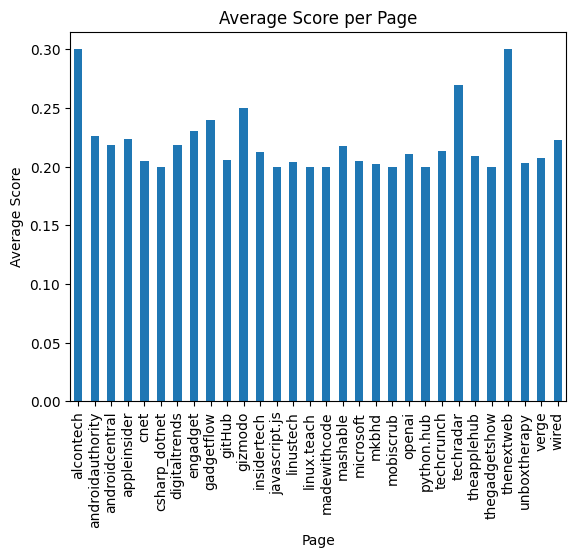

In [8]:
average_scores = user_rating_df.groupby('page')['score'].mean()
average_scores.plot(kind='bar')
plt.xlabel('Page')
plt.ylabel('Average Score')
plt.title('Average Score per Page')
plt.show()